In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('training_set_features.csv'),
                 pd.read_csv('training_set_labels.csv'))
test = pd.read_csv('test_set_features.csv')
sample_submission = pd.read_csv('submission_format.csv')

train.shape, test.shape

((26707, 38), (26708, 36))

In [67]:
train.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [81]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [69]:
def wrangle(X):
    X = X.copy()

    X = X.drop(['respondent_id'], axis=1)

    # X['doctor_recc_h1n1'] = X['doctor_recc_h1n1'].replace(np.nan, 2)
    # X['doctor_recc_seasonal'] = X['doctor_recc_seasonal'].replace(np.nan, 2)

    return X

In [70]:
train = wrangle(train)
test = wrangle(test)


In [71]:
train['doctor_recc_h1n1'].isnull().sum()

2160

In [72]:
target = ['h1n1_vaccine', 'seasonal_vaccine']

train_features = train.drop(target, axis=1)

features = train_features.nunique().index.tolist()

In [73]:
y_train = train[target]
X_train = train[features]

X_test = test[features]

In [74]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.multioutput import MultiOutputClassifier

#When hyperparamater tuning, set tune to "True", and mark each model that we want to tune to "True".
tune = False
forest = True
xgboost = True

forest_distributions = {
    'model__n_estimators': [50, 100, 150, 200, 250, 300, 325, 350],
    'model__max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    'model__max_features': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                            31, 32, 33, 34, 35],
    'model__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8]
}

xgboost_distributions = {
    'model__estimator__n_estimators': [125, 150, 175, 200, 225, 250, 260, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500],
    'model__estimator__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    'model__estimator__learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22, 0.24, 0.26, 0.28, 0.30],
    'model__estimator__min_child_leaf':[1, 2, 3, 4, 5, 6],
    'model__estimator__min_child_weight': [1, 2, 3, 4, 5, 6],
    'model__estimator__colsample_bytree':[0.1, 0.15, 0.2, 0.3, 0.4, 0.50],
    'model__estimator__subsample':[0.6, 0.7, 0.8, 0.9, 1],
    'model__estimator__gamma':[0, 1, 2, 3, 4, 5],
    'model__estimator__scale_pos_weight': [20, 25, 30, 35, 40, 45, 50, 60]
 }

# forest_distributions = {
#     'model__n_estimators': [350, 375, 400, 425],
#     'model__max_depth': [29, 30, 31, 32, 33],
#     'model__max_features': [24, 25, 26, 27],
#     'model__min_samples_leaf': [4]
# }

# xgboost_distributions = {
#     'model__n_estimators': [260, 265, 270],
#     'model__max_depth': [26, 27],
#     'model__learning_rate': [0.08, 0.09],
#     'model__min_child_leaf':[3],
#     'model__min_child_weight': [4],
#     'model__colsample_bytree':[0.2],
#     'model__subsample':[0.9, 1],
#     'model__gamma':[0],
#     'model__scale_pos_weight': [25]
#   }

if tune: #If we are hyperparamater tuning, pass no parameters into estimators and find paramaters via GridSearchCV / RandomizedSearchCV

    import warnings
    warnings.filterwarnings('ignore') #ignore warnings generated by bayes search

    forest_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                                ('imputer', SimpleImputer(strategy='mean')),
                           ('model', RandomForestClassifier(random_state=1337))])

    xgboost_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                                 ('imputer', SimpleImputer(strategy='mean')),
                           ('model', MultiOutputClassifier(XGBClassifier(seed=1337)))])

    forest_search = BayesSearchCV(
        forest_pipeline,
        search_spaces=forest_distributions,
        n_iter=250,
        cv=5,
        scoring='roc_auc',
        random_state=1337,
        n_points=5,
        n_jobs=15
    )
    xgboost_search = BayesSearchCV(
        estimator=xgboost_pipeline,
        search_spaces=xgboost_distributions,
        n_iter=250,
        cv=5,
        scoring='roc_auc',
        random_state=1337,
        n_points=5,
        n_jobs=15
    )

    # forest_search = GridSearchCV(
    #     estimator=forest_pipeline,
    #     param_grid=forest_distributions,
    #     cv=3,
    #     verbose=3,
    #     scoring='f1_micro',
    #     n_jobs=15
    # )
    # xgboost_search = GridSearchCV(
    #     estimator=xgboost_pipeline,
    #     param_grid=xgboost_distributions,
    #     cv=3,
    #     verbose=3,
    #     scoring='f1_micro',
    #     n_jobs=15
    # )

    def report_step_forest(optim_result):
        score = forest_search.best_score_
        print("Random Forest best score: %s" % score)

    def report_step_xgboost(optim_result):
        score = xgboost_search.best_score_
        print("XGboost best score: %s" % score)

    #X_train, y_train = RandomOverSampler(sampling_strategy='not majority').fit_resample(X_train, y_train)

    if forest:
        forest_search.fit(X_train, y_train, callback=report_step_forest)
        forest_train_pred_proba = forest_search.predict_proba(X_train)
        forest_test_pred_proba = forest_search.predict_proba(X_test)

    if xgboost:
        xgboost_search.fit(X_train, y_train, callback=report_step_xgboost)
        xgboost_train_pred_proba = xgboost_search.predict_proba(X_train)
        xgboost_test_pred_proba = xgboost_search.predict_proba(X_test)

    #When hyperparameter tuning, pass our best estimators into votingclassifier. Only run when all 3 models are being tuned.
    # if forest and xgboost:
    #     voting_model = VotingClassifier(estimators=[('forest', forest_search.best_estimator_), #VotingClassifier is Soft Voting/Majority Rule classifier for unfitted estimators
    #                                                 ('xgboost', xgboost_search.best_estimator_),],
    #                                     voting='soft') #soft voting per recommendation from sklearn documentation, when used on tuned classifiers.
    #     voting_model_cv = voting_model
    #     voting_model.fit(X_train, y_train)
    #     combined_model_test_pred = voting_model.predict(X_test)

else: #If we are not hyperparameter tuning, pass in our best params(from previous tuning runs).
    forest_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                                ('imputer', SimpleImputer(strategy='mean')),
                            ('model', RandomForestClassifier(random_state=1337, n_jobs=15, max_depth=22,
                                                             min_samples_leaf=6, max_features=6, n_estimators=350))])

    xgboost_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                                 ('imputer', SimpleImputer(strategy='mean')),
                                 #('imputer', KNNImputer()),
                                ('model', MultiOutputClassifier(XGBClassifier(seed=1337, n_jobs=15, colsample_bytree=0.3, gamma=3,
                                                        learning_rate=0.1, max_depth=3, min_child_leaf=1, min_child_weight=5,
                                                        n_estimators=375, scale_pos_weight=20, subsample=0.9)))])


    #X_train, y_train = RandomOverSampler(sampling_strategy='minority').fit_resample(X_train, y_train) #over sample all but the majority class

    forest_pipeline_cv = forest_pipeline
    forest_pipeline.fit(X_train, y_train)
    forest_train_pred_proba = forest_pipeline.predict_proba(X_train)
    forest_test_pred_proba = forest_pipeline.predict_proba(X_test)

    xgboost_pipeline_cv = xgboost_pipeline
    xgboost_pipeline.fit(X_train, y_train)
    xgboost_train_pred_proba = xgboost_pipeline.predict_proba(X_train)
    xgboost_test_pred_proba = xgboost_pipeline.predict_proba(X_test)

    # voting_model = VotingClassifier(estimators=[('forest', forest_pipeline), #VotingClassifier is Soft Voting/Majority Rule classifier for unfitted estimators
    #                                             ('xgboost', xgboost_pipeline),],
    #                                 voting='soft') #soft voting per recommendation from sklearn documentation, when used on tuned classifiers.
    # voting_model_cv = voting_model
    # voting_model.fit(X_train, y_train)
    # combined_model_test_pred = voting_model.predict(X_test)


In [75]:
from sklearn.metrics import f1_score, classification_report, roc_auc_score
import numpy as np
if tune:
    if forest:
        print(forest_search.best_params_, '\n')
        print("Best Random Forest CV score: ", forest_search.best_score_, '\n')
        print('\n')

    if xgboost:
        print(xgboost_search.best_params_, '\n')
        print("Best xgboost CV score: ", xgboost_search.best_score_, '\n')
        print('\n')

    # if forest and xgboost:
    #     #print("Voting classifier, final F1-Micro score on validation set: ", f1_score(y_validation, combined_model_pred, average='micro'))
    #     print("Voting classifier, final F1-Micro cross-validation score: ", np.mean(cross_val_score(voting_model_cv, X_train,
    #                                                                                         y_train, scoring='f1_micro',
    #                                                                                         cv=3, n_jobs=15)))
else:
    # print("Random forest F1-Micro cross-validation score: ", np.mean(cross_val_score(forest_pipeline_cv, X_train,
    #                                                                          y_train, scoring='f1_micro', cv=3,
    #                                                                          n_jobs=15)), '\n')
    # print('\n')

    print("Random forest ROC AUC cross validation score: ", np.mean(cross_val_score(forest_pipeline_cv, X_train, y_train, scoring='roc_auc', cv=5,
                                                n_jobs=14)), '\n')


    print('\n')

    print("Random forest ROC AUC cross validation score: ", np.mean(cross_val_score(xgboost_pipeline_cv, X_train, y_train, scoring='roc_auc', cv=5,
                                                n_jobs=14)), '\n')

    #print("Random forest ROC AUC training score: ", roc_auc_score(y_train, forest_train_pred_proba))
    #
    # print("Voting classifier, final F1-Micro cross-validation score: ", np.mean(cross_val_score(voting_model_cv, X_train,
    #                                                                                         y_train, scoring='f1_micro',
    #                                                                                         cv=3, n_jobs=15)))

Random forest ROC AUC cross validation score:  0.8588576121839241 



Random forest ROC AUC cross validation score:  0.8655090313204752 



In [76]:

# Make sure we have the rows in the same order
submission = sample_submission.copy()
np.testing.assert_array_equal(X_test.index.values,
                              submission.index.values)

# Save predictions to submission data frame
submission["h1n1_vaccine"] = forest_test_pred_proba[0][:, 1]
submission["seasonal_vaccine"] = forest_test_pred_proba[1][:, 1]
submission.to_csv('random_forest.csv', index=False)

submission = sample_submission.copy()
np.testing.assert_array_equal(X_test.index.values,
                              submission.index.values)

submission["h1n1_vaccine"] = xgboost_test_pred_proba[0][:, 1]
submission["seasonal_vaccine"] = xgboost_test_pred_proba[1][:, 1]
submission.to_csv('xgboost.csv', index=False)

In [77]:
submission.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.748527,0.876982
1,26708,0.344693,0.294949
2,26709,0.802015,0.979315
3,26710,0.967905,0.992940
4,26711,0.929897,0.952205


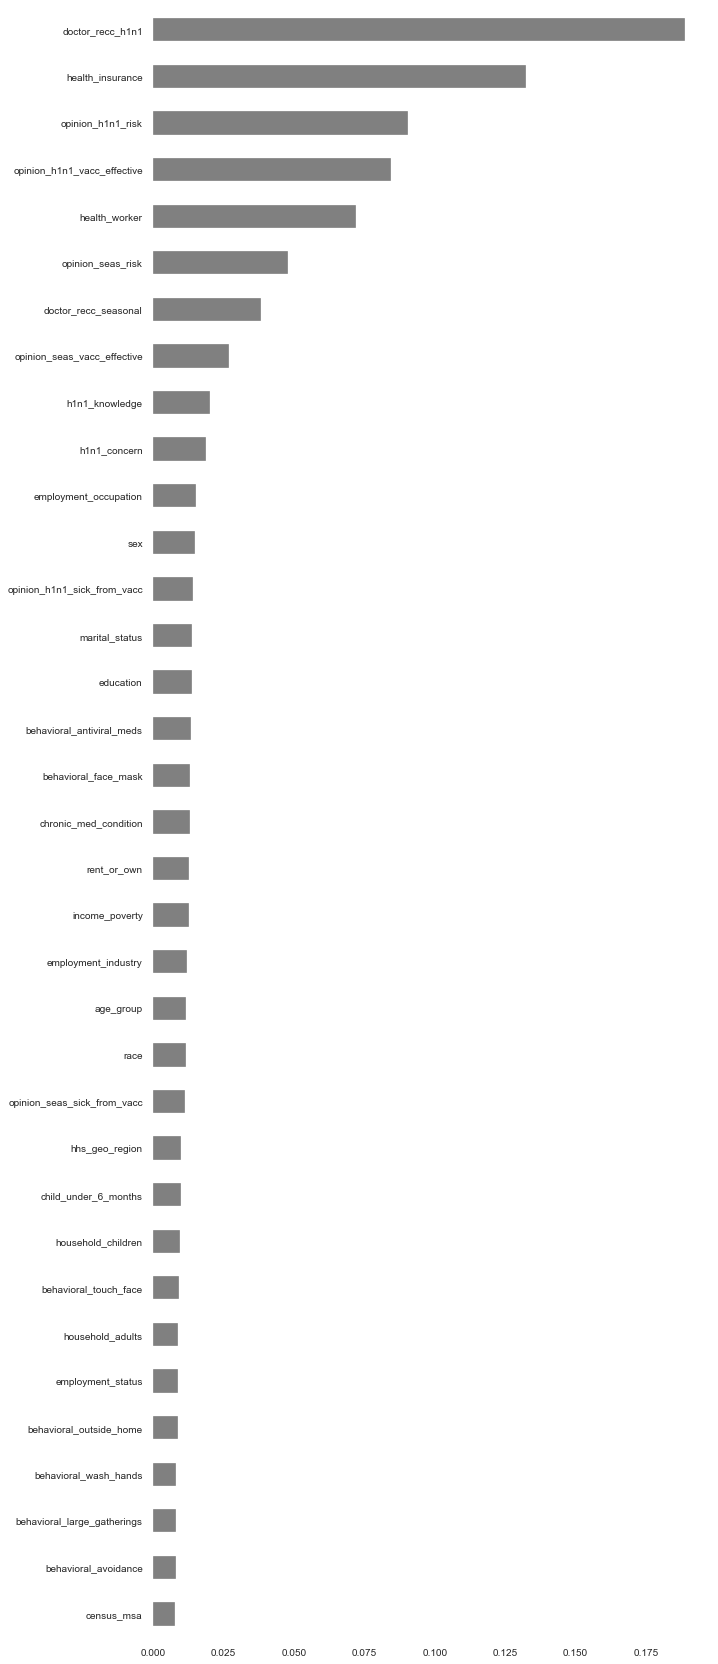

In [78]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
#cross_validate()

# if tune:
#     model = forest_search.best_estimator_.named_steps.model
#     encoder = forest_search.best_estimator_.named_steps.encoder
# else:
#     model = xgboost_pipeline.named_steps.model
#     encoder = xgboost_pipeline.named_steps.encoder

encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

model = MultiOutputClassifier(XGBClassifier(seed=1337, n_jobs=15, colsample_bytree=0.3, gamma=3,
                                                        learning_rate=0.1, max_depth=3, min_child_leaf=1, min_child_weight=5,
                                                        n_estimators=375, scale_pos_weight=20, subsample=0.9))


model.fit(X_train_imputed, y_train)

encoded_columns = X_train_encoded.columns
importances = pd.Series(model.estimators_[0].feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');


In [79]:
train['doctor_recc_h1n1'].value_counts()

0.0    19139
1.0     5408
Name: doctor_recc_h1n1, dtype: int64

In [80]:
X_train_encoded['doctor_recc_h1n1'].value_counts()


0.0    19139
1.0     5408
Name: doctor_recc_h1n1, dtype: int64

In [85]:
# train[['chronic_med_condition', 'doctor_recc_h1n1']].corr()
train.corr()


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
h1n1_concern,1.000000,0.062522,0.090301,0.233713,0.156032,0.293565,0.255031,0.246424,0.248016,0.150206,...,0.239604,0.377033,0.360070,0.235136,0.333990,0.225731,-0.015658,0.050525,0.121929,0.154828
h1n1_knowledge,0.062522,1.000000,-0.010836,0.088839,0.030050,0.089785,-0.048898,-0.068219,0.086162,0.093829,...,0.121009,0.073086,-0.019501,0.086103,0.076825,-0.062483,0.024874,0.050583,0.117951,0.120152
behavioral_antiviral_meds,0.090301,-0.010836,1.000000,0.049247,0.146261,0.064119,0.106287,0.127679,0.070868,0.051235,...,0.030211,0.105163,0.079091,0.015003,0.085315,0.084305,0.044900,0.084822,0.040608,0.006277
behavioral_avoidance,0.233713,0.088839,0.049247,1.000000,0.064946,0.338130,0.227675,0.220348,0.335335,0.068145,...,0.112300,0.117851,0.131405,0.119554,0.129504,0.082942,0.019122,0.040328,0.047690,0.076395
behavioral_face_mask,0.156032,0.030050,0.146261,0.064946,1.000000,0.083363,0.180907,0.163382,0.104335,0.084282,...,0.037651,0.131165,0.107129,0.041556,0.110161,0.090009,0.013991,0.005826,0.070498,0.050083
behavioral_wash_hands,0.293565,0.089785,0.064119,0.338130,0.083363,1.000000,0.195364,0.192619,0.365064,0.088729,...,0.136987,0.168711,0.150024,0.138517,0.172464,0.088029,0.009669,0.047764,0.074712,0.112414
behavioral_large_gatherings,0.255031,-0.048898,0.106287,0.227675,0.180907,0.195364,1.000000,0.584085,0.253683,0.082242,...,0.052299,0.126463,0.185924,0.078491,0.132865,0.135446,-0.031938,-0.009449,0.017822,0.064025
behavioral_outside_home,0.246424,-0.068219,0.127679,0.220348,0.163382,0.192619,0.584085,1.000000,0.267719,0.070346,...,0.050748,0.125549,0.174834,0.067469,0.120237,0.138133,-0.027527,-0.009558,0.021768,0.053509
behavioral_touch_face,0.248016,0.086162,0.070868,0.335335,0.104335,0.365064,0.253683,0.267719,1.000000,0.088221,...,0.104126,0.146080,0.131772,0.105798,0.143735,0.090097,-0.000553,0.023606,0.071648,0.120228
doctor_recc_h1n1,0.150206,0.093829,0.051235,0.068145,0.084282,0.088729,0.082242,0.070346,0.088221,1.000000,...,0.152305,0.262826,0.113111,0.107512,0.202320,0.057128,0.004112,0.029040,0.393890,0.198607


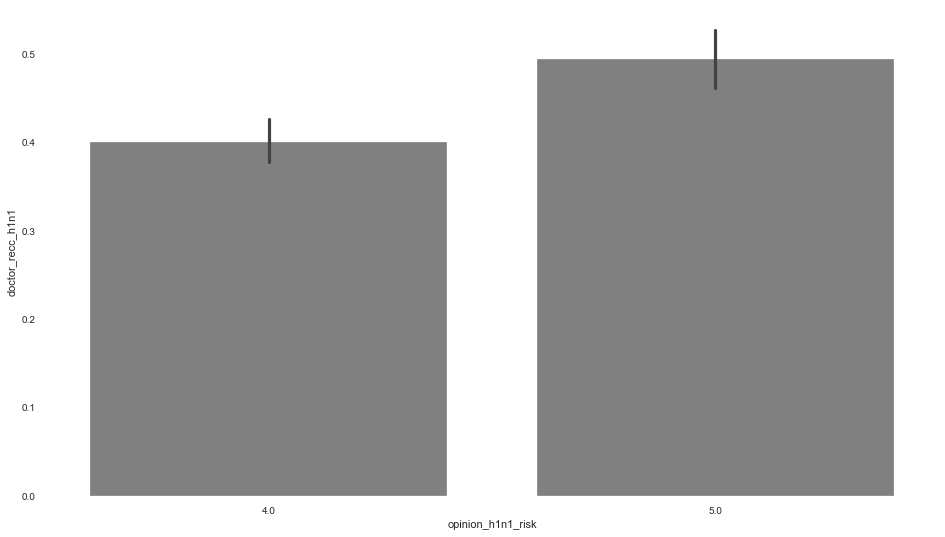

In [90]:
import matplotlib.pyplot as plt

import seaborn as sns
plt.figure(figsize=(16,9))
sns.barplot(
    x=train[(train['opinion_h1n1_risk'] >= 4) & (train['h1n1_concern'] == 3)],
    #x=train['opinion_h1n1_risk'],
    y=train['doctor_recc_h1n1'],
    color='grey'
);

In [87]:
train['opinion_h1n1_risk'].value_counts()

2.0    9919
1.0    8139
4.0    5394
5.0    1750
3.0    1117
Name: opinion_h1n1_risk, dtype: int64

In [88]:
train['h1n1_concern'].value_counts()


2.0    10575
1.0     8153
3.0     4591
0.0     3296
Name: h1n1_concern, dtype: int64

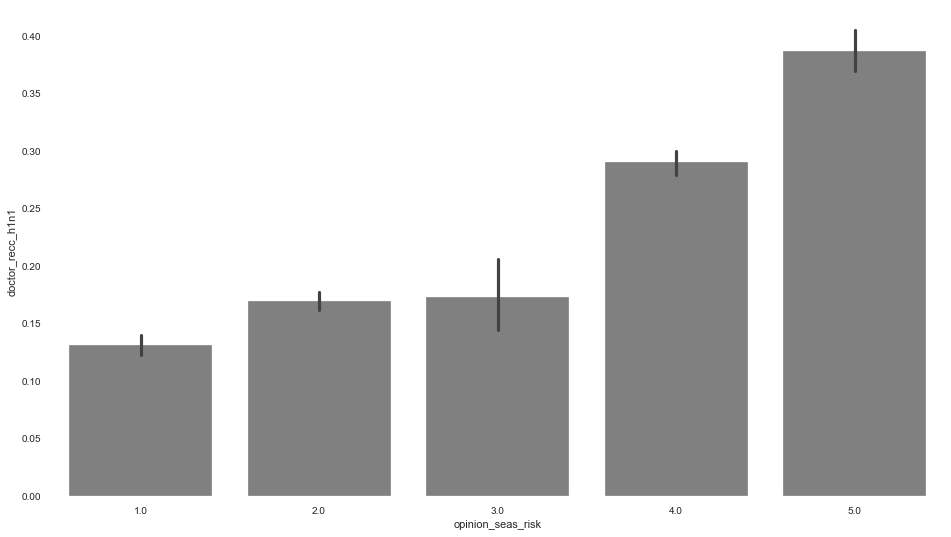

In [107]:
plt.figure(figsize=(16,9))
sns.barplot(
    x=train['opinion_seas_risk'],
    y=train['doctor_recc_h1n1'],
    color='grey'
);

In [127]:
new_df = train.copy()
#new_df = train[(train['opinion_h1n1_risk'] >= 4) & (train['h1n1_concern'] == 3)]

def test(row):
    if row['opinion_h1n1_risk'] > 4 and row['h1n1_concern'] == 3:
        val = 1
    else:
        val = 0
    return val

new_df['new_feature'] = new_df.apply(test, axis=1)


In [128]:
new_df[['opinion_h1n1_risk', 'doctor_recc_h1n1']].corr()

,opinion_h1n1_risk,doctor_recc_h1n1
opinion_h1n1_risk,1.000000,0.262826
doctor_recc_h1n1,0.262826,1.000000


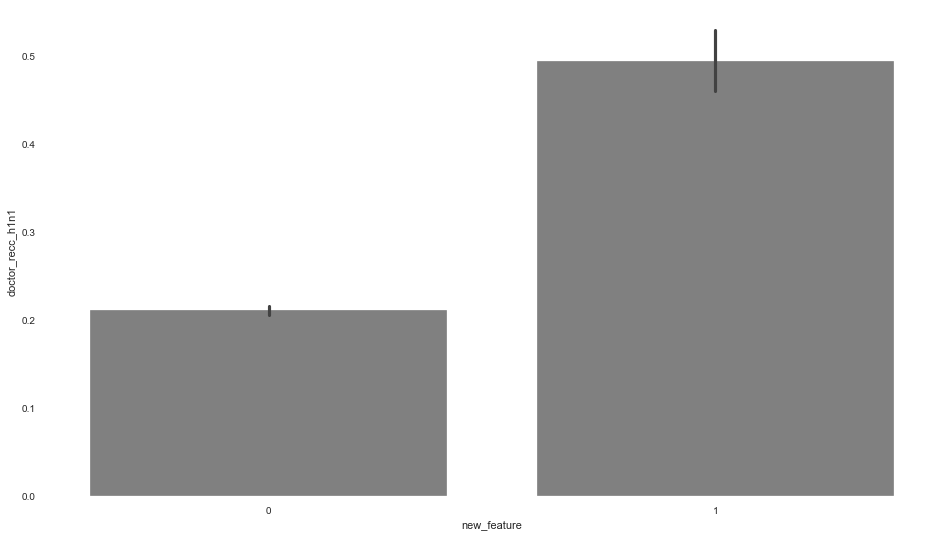

In [129]:
plt.figure(figsize=(16,9))
sns.barplot(
    x=new_df['new_feature'],
    y=new_df['doctor_recc_h1n1'],
    color='grey'
);

In [130]:
#new_df['new_feature'].value_counts()

new_df[new_df['doctor_recc_h1n1'].isnull()]['new_feature'].value_counts()


0    2085
1      75
Name: new_feature, dtype: int64

In [131]:
train['opinion_seas_risk'].value_counts()

2.0    8954
4.0    7630
1.0    5974
5.0    2958
3.0     677
Name: opinion_seas_risk, dtype: int64

In [132]:
new_df[new_df['doctor_recc_h1n1'].isnull()]

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine,new_feature
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0,0
76,2.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,Employed,fpwskwrf,"MSA, Principle City",1.0,0.0,ldnlellj,xzmlyyjv,0,0,0
90,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,...,Employed,lrircsnp,Non-MSA,0.0,0.0,fcxhlnwr,vlluhbov,0,1,0
94,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,...,NaN,kbazzjca,"MSA, Not Principle City",1.0,3.0,NaN,NaN,0,0,0
97,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,...,Not in Labor Force,fpwskwrf,"MSA, Principle City",1.0,0.0,NaN,NaN,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26675,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,...,NaN,kbazzjca,Non-MSA,1.0,1.0,NaN,NaN,0,1,0
26679,3.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,...,Employed,kbazzjca,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0,0
26682,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,...,Employed,lrircsnp,"MSA, Not Principle City",1.0,2.0,vjjrobsf,hfxkjkmi,0,0,0
26692,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,...,Employed,atmpeygn,Non-MSA,1.0,2.0,ldnlellj,oijqvulv,0,0,0


In [133]:
new_df = new_df.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis=1)

target = ['doctor_recc_h1n1']

train_features = new_df.drop(target, axis=1)

features = train_features.nunique().index.tolist()